# File: Use an LSTM model to predict ideal pitch sequencing between any pitcher/hitter pair

In [159]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [48]:
# Load each hitter dataset
hitter_hhm = pd.read_csv('hitter_horizontal_movement.csv')
hitter_hvm = pd.read_csv('hitter_vertical_movement.csv')
hitter_hpvs = pd.read_csv('hitter_pitch_values.csv')
hitter_hvs = pd.read_csv('hitter_velocities_seen.csv')
hitter_pd = pd.read_csv('hitter_plate_discipline.csv')

# Drop the columns PA, NameASCII, PlayerId, Team, and Name from all dataframes except 'hitter_hhm'
hitter_hhm = hitter_hhm.drop(columns=['NameASCII', 'PlayerId'], errors='ignore')
hitter_hvm = hitter_hvm.drop(columns=['PA', 'NameASCII', 'PlayerId', 'Team', 'Name'], errors='ignore')
hitter_hpvs = hitter_hpvs.drop(columns=['PA', 'NameASCII', 'PlayerId', 'Team', 'Name'], errors='ignore')
hitter_hvs = hitter_hvs.drop(columns=['PA', 'NameASCII', 'PlayerId', 'Team', 'Name'], errors='ignore')
hitter_pd = hitter_pd.drop(columns=['PA', 'NameASCII', 'PlayerId', 'Team', 'Name'], errors='ignore')

# Merge them on 'MLBAMID'
hitter_data = hitter_hhm.merge(hitter_hvs, on='MLBAMID', how='left') \
                        .merge(hitter_hpvs, on='MLBAMID', how='left') \
                        .merge(hitter_hvm, on='MLBAMID', how='left') \
                        .merge(hitter_pd, on='MLBAMID', how='left')

column_order = ['MLBAMID', 'Name', 'Team'] + [col for col in hitter_data.columns if col not in ['MLBAMID', 'Name', 'Team']]
hitter_data = hitter_data[column_order]

# Save the merged data to a new CSV
hitter_data.to_csv('merged_hitter_data2.csv', index=False)

print("Hitter data merged correctly, including all metrics.")

Hitter data merged correctly, including all metrics.


In [100]:
# Load pitcher datasets
pitcher_arsenals = pd.read_csv('pitcher_arsenals.csv')
plate_discipline = pd.read_csv('plate_discipline.csv')
stuff_plus = pd.read_csv('stuff_plus.csv')

# Drop unnecessary columns from pitcher_arsenals and plate_discipline (but keep 'last_name, first_name')
pitcher_arsenals = pitcher_arsenals.drop(columns=['NameASCII', 'PlayerID'], errors='ignore')
plate_discipline = plate_discipline.drop(columns=['last_name, first_name'], errors='ignore')

# Drop 'PlayerID' and 'NameASCII' from stuff_plus, and rename 'MLBAMID' to 'player_id'
stuff_plus = stuff_plus.drop(columns=['PlayerID', 'NameASCII'], errors='ignore')
stuff_plus = stuff_plus.rename(columns={'MLBAMID': 'player_id'})

# Merge pitcher datasets on 'player_id' (first merge the arsenals and plate discipline)
pitcher_data = pitcher_arsenals.merge(plate_discipline, on='player_id', how='left')

# Now merge the stuff_plus dataset, which contains 'Name', 'Team', and other metrics, on 'player_id'
pitcher_data = pitcher_data.merge(stuff_plus, on='player_id', how='left')

# Fill missing Name values: if not in stuff_plus, use 'last_name, first_name' column from pitcher_arsenals
pitcher_data['Name'] = pitcher_data['Name'].fillna(
    pitcher_data['last_name, first_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]) if isinstance(x, str) else '')
)

# Fill missing Team values from stuff_plus
pitcher_data['Team'] = pitcher_data['Team'].fillna('')

# Drop 'last_name, first_name' column after it's been used
pitcher_data = pitcher_data.drop(columns=['last_name, first_name'], errors='ignore')

# Reorder columns to ensure the first three are: player_id, Name, Team
column_order = ['player_id', 'Name', 'Team'] + [col for col in pitcher_data.columns if col not in ['player_id', 'Name', 'Team']]
pitcher_data = pitcher_data[column_order]

# Save the merged data to a new CSV
pitcher_data.to_csv('merged_pitcher_data.csv', index=False)

print("Pitcher data merged and reordered successfully.")

Pitcher data merged and reordered successfully.


In [101]:
# Load pitcher datasets
pitcher_arsenals = pd.read_csv('pitcher_arsenals.csv')
plate_discipline = pd.read_csv('plate_discipline.csv')
stuff_plus = pd.read_csv('stuff_plus.csv')

# Rename 'MLBAMID' to 'player_id' in stuff_plus
stuff_plus = stuff_plus.rename(columns={'MLBAMID': 'player_id'})

# Perform inner joins to keep only players present in all three datasets
pitcher_data = pitcher_arsenals.merge(plate_discipline, on='player_id', how='inner')
pitcher_data = pitcher_data.merge(stuff_plus, on='player_id', how='inner')

# Reorder columns to ensure the first three are: player_id, Name, Team
column_order = ['player_id', 'Name', 'Team'] + [col for col in pitcher_data.columns if col not in ['player_id', 'Name', 'Team']]
pitcher_data = pitcher_data[column_order]

# Save the merged data to a new CSV
pitcher_data.to_csv('merged_pitcher_data_inner.csv', index=False)

print("Pitcher data merged successfully with only players appearing in all three datasets.")


Pitcher data merged successfully with only players appearing in all three datasets.


In [151]:
pitch_data = pd.read_csv("pitch_data_ids.csv")
hitter_data = pd.read_csv("merged_hitter_data.csv")
pitcher_data = pd.read_csv("merged_pitcher_data.csv")

# Split the 'hitter_name' into 'last name' and 'first name' to fix formatting later
pitch_data[['last_name', 'first_name']] = pitch_data['hitter_name'].str.split(',', expand=True)

# Strip any extra spaces from 'first_name' and 'last_name'
pitch_data['first_name'] = pitch_data['first_name'].str.strip()
pitch_data['last_name'] = pitch_data['last_name'].str.strip()

# Change into 'first-name last-name' format to match other CSVs
pitch_data['hitter_name_corrected'] = pitch_data['first_name'] + ' ' + pitch_data['last_name']

# Merge with hitter_data using the corrected 'hitter_name'
pitch_data = pitch_data.merge(hitter_data, left_on="hitter_name_corrected", right_on="Name", how="left")
pitch_data = pitch_data.merge(pitcher_data, left_on="reliever", right_on="player_id", how="left")
print(pitch_data.shape)

# Sort by game and at-bat to maintain sequence integrity
pitch_data = pitch_data.sort_values(by=["game_id", "at_bat_id", "pitch_number"])

# Convert 'count' to 'balls' and 'strikes'
pitch_data[['balls', 'strikes']] = pitch_data['count'].str.split('-', expand=True).astype(int)
print(pitch_data[['count', 'inning', 'balls', 'strikes']].head())

# Convert 'inning' to numerical
pitch_data['inning_number'] = pitch_data['inning'].str[1:].astype(int)
pitch_data['inning_half'] = pitch_data['inning'].str[0].map({'T': 0, 'B': 1})

# Create previous pitch features to add more context
pitch_data["pitch_type_prev"] = pitch_data.groupby("at_bat_id")["pitch_type"].shift(1)
pitch_data["outcome_prev"] = pitch_data.groupby("at_bat_id")["outcome"].shift(1)
print(pitch_data[['pitch_type', 'pitch_type_prev', 'outcome_prev']].head())
print(pitch_data['count'].head())

# Drop NaN values
#pitch_data = pitch_data.dropna()

# Encode categorical features
label_encoders = {}
categorical_features = ["pitch_type", "pitch_type_prev", "outcome_prev", "bat_side"]
for feature in categorical_features:
    le = LabelEncoder()
    pitch_data[feature] = le.fit_transform(pitch_data[feature])
    label_encoders[feature] = le

# Select features and target
features = [
    # Pitch-by-pitch metrics
    "balls", "strikes", "inning_number", "inning_half", "pitch_number", "velocity", 
    "pitch_type_prev", "outcome_prev",
    
    # Hitter Metrics
    "O-Swing%", "Z-Swing%", "Swing%", "O-Contact%", "Z-Contact%", "Contact%", "Zone%", 
    "F-Strike%", "SwStr%", "CStr%", "CSW%",

    # Pitcher Metrics
    "ff_avg_speed", "ff_avg_spin", "ff_avg_break_x", "ff_avg_break_z_induced",
    "sl_avg_speed", "sl_avg_spin", "sl_avg_break_x", "sl_avg_break_z_induced",
    "whiff_percent", "edge_percent", "in_zone_percent"
]
target = "pitch_type"

X = pitch_data[features]
y = pitch_data[target]

# Fill in missing values with the mean 
# This is experimental right now
X = X.fillna(X.mean())

# Standardize numerical features
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Reshape for LSTM
X = np.array(X).reshape((X.shape[0], 1, X.shape[1]))
y = np.array(y)

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(len(label_encoders["pitch_type"].classes_), activation="softmax")
])

# Compile
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save
model.save("pitch_sequencing_model.h5")

(168465, 223)
  count inning  balls  strikes
0   0-0     T8      0        0
1   0-1     T8      0        1
2   1-1     T8      1        1
3   2-1     T8      2        1
4   3-1     T8      3        1
  pitch_type pitch_type_prev   outcome_prev
0         FC             NaN            NaN
1         FF              FC  Called Strike
2         SL              FF           Ball
3         FC              SL           Ball
4         FF              FC           Ball
0    0-0
1    0-1
2    1-1
3    2-1
4    3-1
Name: count, dtype: object
Epoch 1/10


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4212/4212 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5911 - loss: 1.1041 - val_accuracy: 0.7588 - val_loss: 0.6119
Epoch 2/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7401 - loss: 0.6550 - val_accuracy: 0.8106 - val_loss: 0.4954
Epoch 3/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7783 - loss: 0.5637 - val_accuracy: 0.8286 - val_loss: 0.4362
Epoch 4/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7998 - loss: 0.5095 - val_accuracy: 0.8465 - val_loss: 0.3928
Epoch 5/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8097 - loss: 0.4809 - val_accuracy: 0.8507 - val_loss: 0.3747
Epoch 6/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8198 - loss: 0.4542 - val_accuracy: 0.8590 - val_loss: 0.3533
Epoch 7/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8220 - loss: 0.4431 - val_accuracy: 0.8621 - val_loss: 0.3418
Epoch 8/10
4212/4212 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8278 - loss: 0.4276 - val

In [152]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8690 - loss: 0.3177
Test Loss: 0.31995120644569397
Test Accuracy: 0.8689045310020447


In [153]:
# Make predictions using test set
y_pred = model.predict(X_test)

# y_pred = predicted probabilities
# o choose the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Show first 10 predictions with true values
print("Predicted classes:", y_pred_classes[:10])
print("True values:", y_test[:10])

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicted classes: [2 0 3 3 8 8 3 4 8 2]
True values: [2 2 3 3 3 8 3 4 8 2]


In [154]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1807   15  139   15    2    4    0    0    5  394  170    5]
 [  11 1347    0    0    0    0    0    0    0   15   36   12]
 [ 123    4 2250   47   36    7    0    0   93   79   18    0]
 [   7    0   47 9468    6    0    0    0  899    3    0    0]
 [   2    2    9    5  945    0    0    0    1   53   25    0]
 [  23    2    0    0    0  383    0    0    0    2    1    0]
 [   0    0    1    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0   23    0    0    0    0]
 [   1    0  116 1297    2    0    0    0 4851    6    0    0]
 [ 181   31   62    6   90   16    0    0   13 6054  148    5]
 [  11   25   12    0   31    2    0    0    0   39 2072    0]
 [   0    3    0    0    0    0    0    0    0    1    0   76]]


In [155]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2556
           1       0.94      0.95      0.95      1421
           2       0.85      0.85      0.85      2657
           3       0.87      0.91      0.89     10430
           4       0.85      0.91      0.88      1042
           5       0.93      0.93      0.93       411
           6       0.00      0.00      0.00         2
           7       1.00      1.00      1.00        23
           8       0.83      0.77      0.80      6273
           9       0.91      0.92      0.91      6606
          10       0.84      0.95      0.89      2192
          11       0.78      0.95      0.85        80

    accuracy                           0.87     33693
   macro avg       0.80      0.82      0.81     33693
weighted avg       0.87      0.87      0.87     33693



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


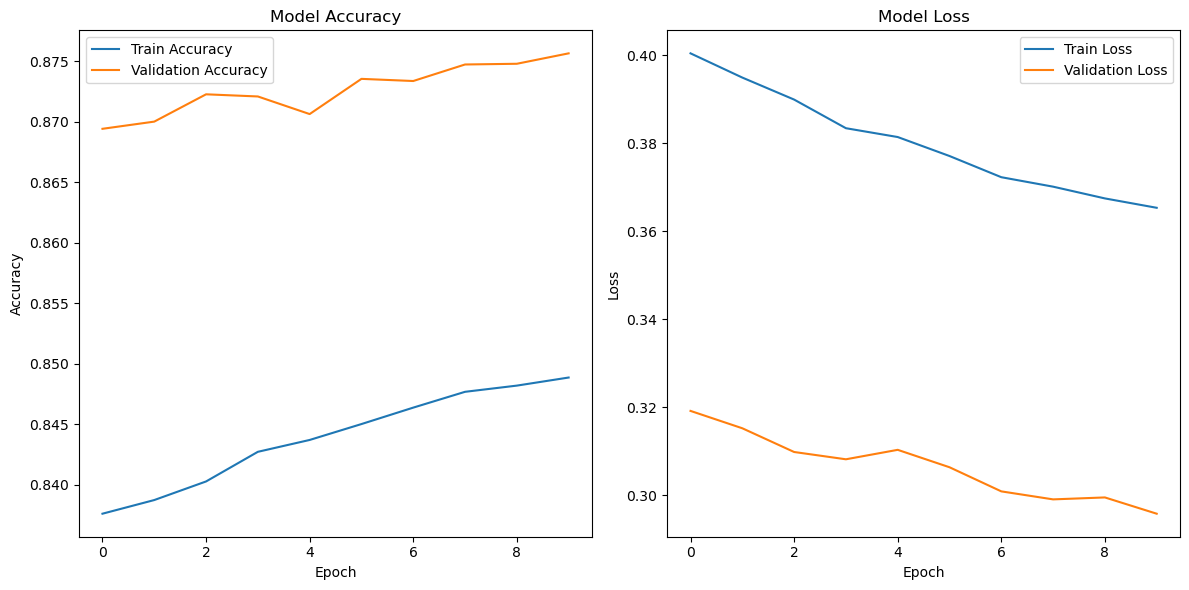

In [158]:
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()